In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pointCollection as pc
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
# temporary directory:
test_dir='../test_data/for_geoindex'


# The geoIndex class
The GeoIndex class is designed to allow us to find data for a specific area from a file or a collection of files.  It works by subdividing the data into bins, and keeping track of where in a file each particular bin is found.  To illustrate how it works, we will make a simple data set, and generate an index for it.

First, we'll generate a set of data:

Text(0.5, 1.0, 'example data')

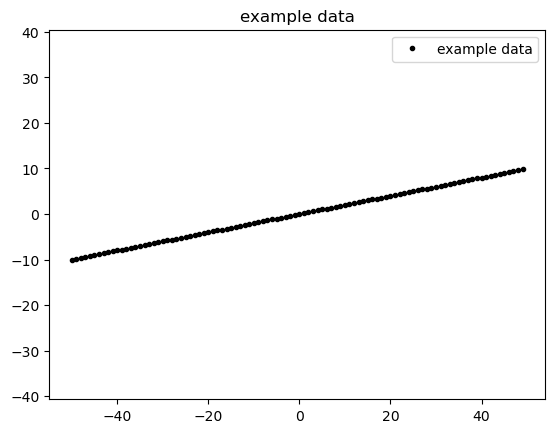

In [3]:
# define a set of data points:
x=np.arange(-50, 50, dtype=np.float64)
y=0.2*x
t=np.ones_like(x)
z=x**2+y**2
plt.figure(1); plt.clf()
plt.plot(x, y,'k.', label='example data')
plt.axis('equal')
plt.legend()
plt.gca().set_title('example data')

Next, we'll generate a geoIndex for the points, with 10-unit bins. We'll use the geoIndex.from_xy() method, which makes a geoIndex for based on the data locations.

In [4]:
gi=pc.geoIndex(delta=[10, 10]).from_xy([x, y])
print(gi)

<class 'pointCollection.geoIndex.geoIndex'> with 11 bins, referencing 1 files


A geoIndex is just a subclass of a dict, so it has a keys() method.  Each key is the x and y coordinates of the bin, separated by an underscore.  

In [5]:
gi.keys()

dict_keys(['0_0', '-10_0', '10_0', '-20_0', '20_0', '-30_-10', '30_10', '-40_-10', '40_10', '-50_-10', '50_10'])

Next, let's plot the bin locations. The geoIndex.bins_as_array() method, which returns the locations of the bins in the geoIndex as a list of two arrays:

Text(0.5, 1.0, 'sample data and bin centers')

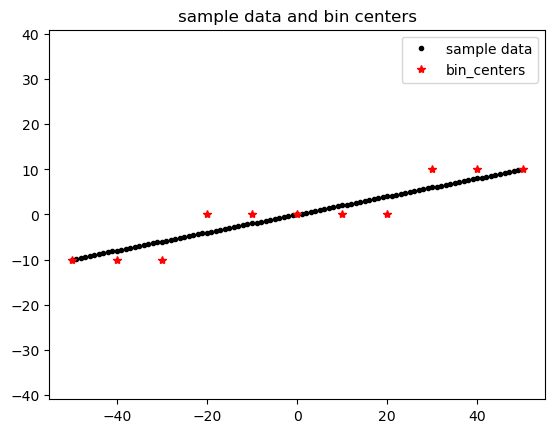

In [6]:
# plot the data and the bins
plt.figure(1); plt.clf()
plt.plot(x, y,'k.', label='sample data')
xyb=gi.bins_as_array()
plt.plot(xyb[0], xyb[1],'r*', label='bin_centers')
plt.axis('equal');
plt.legend()
plt.gca().set_title('sample data and bin centers')

We can then query the geoIndex for the data associated with a particular bin. To get the data associated with the bin at (10, 0), we just index it with that bin's keys:

In [7]:
Q=gi['10_0']
print(Q)

{'file_num': array([0]), 'offset_start': array([56]), 'offset_end': array([64])}


This tells us that the data for the bin at (10,0) has indices between 56 and 64.

Text(0.5, 1.0, 'example data selection')

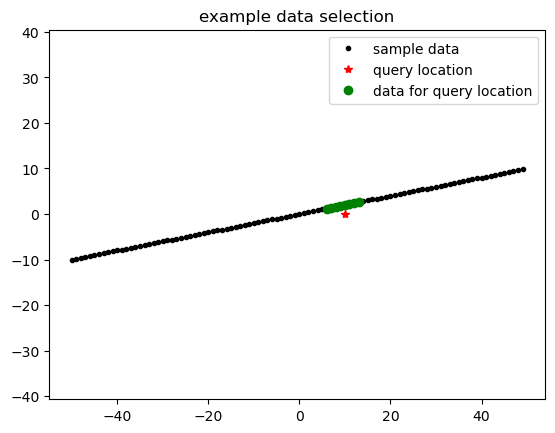

In [8]:
this_index=np.arange(Q['offset_start'], Q['offset_end'])
plt.plot(x,y,'k.', label='sample data')
plt.plot(10,0,'r*', label='query location')
plt.plot(x[this_index], y[this_index],'go', label='data for query location')
plt.axis('equal');
plt.legend()

plt.gca().set_title('example data selection')


To avoid generating bin names by hand, we can just call the query_xy() method, which takes a tuple of two numpy arrays containing the bin locations.  This can be done for multiple bins, and the results will be stitched together into a useful set of query results.
## The Geoindex class for files on disk
The class is much more useful when we have a number of datasets on disk and we need to index them as a group.  Let's make a some data files on disk, which will be a set of diagonal parallel lines of points:

In [9]:
if not os.path.isdir(test_dir):
    os.mkdir(test_dir)
for offset in np.arange(-40, 50, 10):
    out_file=test_dir+'/data_%d.h5' % offset
    pc.data().from_dict({'x':x,'y':y+offset, 'z':x**2+(y+offset)**2, 'time':t*offset}).to_h5(out_file, replace=True)

Let's make a geoIndex for the files and look at it.

Text(0.5, 1.0, 'bin centers for test data')

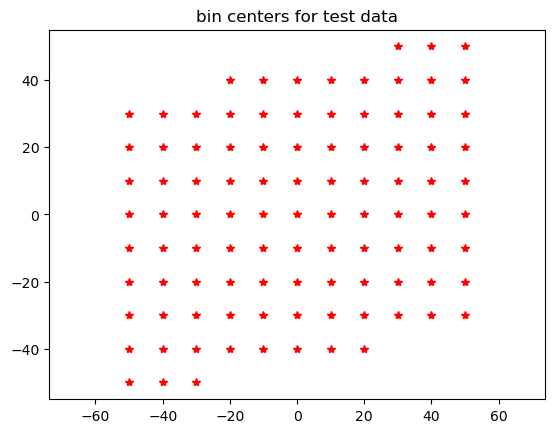

In [10]:
test_files=glob.glob(test_dir+'/data*.h5')
gi_2=pc.geoIndex(delta=[10,10]).for_files(test_files,'h5')
xy_bin=gi_2.bins_as_array()
plt.figure(); 
plt.plot(xy_bin[0], xy_bin[1],'r*', label='bin centers')
plt.axis('equal')
plt.gca().set_title('bin centers for test data')

Looking at the entry for a particular bin shows how we store the index information:

In [11]:
print(gi_2['20_-20'])
print(gi_2.attrs['file_4'])
print(gi_2.attrs['file_5'])

{'file_num': array([3, 6]), 'offset_start': array([75, 65]), 'offset_end': array([75, 75])}
../test_data/for_geoindex/data_0.h5
../test_data/for_geoindex/data_10.h5


The contents of gi_2 at (20, -20) indicate that the data are in file number 4 for indices between 65 and 75, and in file 5, for indices between 75 and 75 (inclusive).  files 4 and 5 are test_data/for_geoindex/data_-20.h5
test_data/for_geoindex/data_-30.h5, respectively.

Let's retrieve the data for three bins:

In [12]:
xy_query = (np.array([10,20, 30, 40]), np.array([20, 20, 20, 20]))

D=gi_2.query_xy(xy_query, fields={None:['x','y']})
print(D)

[<class 'pointCollection.data.data'> with shape (20,),
with fields:
['x', 'y'], <class 'pointCollection.data.data'> with shape (19,),
with fields:
['x', 'y']]


The result is a list of two pc.data objects, that together contain the data we requested:

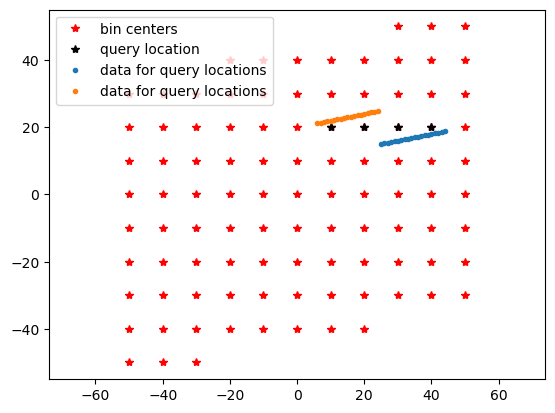

In [13]:
plt.plot(xy_bin[0], xy_bin[1],'r*', label='bin centers')
plt.plot(xy_query[0], xy_query[1],'k*', label='query location')
plt.axis('equal')
for Di in D: 
    plt.plot(Di.x, Di.y,'.', label='data for query locations')
plt.legend()

We can also query a range of bins using the query_xy_box() method.  Let's get all the data for bins between x=0 and x=30, and for bins between y=-20 and y=20.

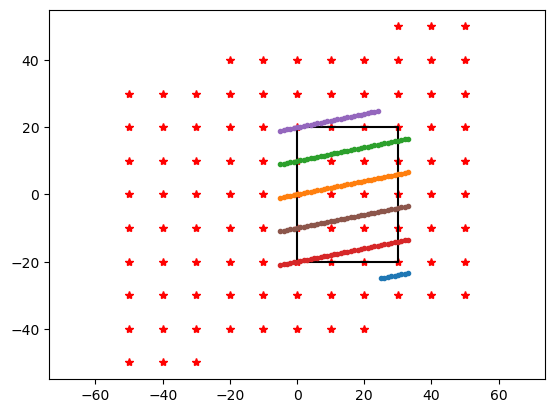

In [14]:
XR=np.array([0, 30])
YR=np.array([-20, 20])

D=gi_2.query_xy_box(XR, YR, fields={None:['x','y']})
plt.plot(xy_bin[0], xy_bin[1],'r*', label='bin centers')
plt.axis('equal')
plt.plot(XR[[0, 0, 1, 1, 0]], YR[[0, 1, 1, 0, 0]],'k', label='query box')

for Di in D: 
    plt.plot(Di.x, Di.y,'.', label='data returned for box')


Note that the recovered data extend outside the box that we specified, because query_xy_box finds the data for the bin centers within the box, and each bin extends 1/2 of the bin spacing around its center.

## Changing data paths
Let's look again at how the files containing the data in gi_2 are specified:

In [15]:
print(gi_2.attrs['file_0'])

../test_data/for_geoindex/data_-40.h5


The files specified relative to the current directory, which means that if we use the geoindex from a different directory, it won't work.  The way to fix this is to specify a 'dir_root' attribute for the index during its creation.  The files will then be specified relative to that location.

In [16]:
gi_3=pc.geoIndex(delta=[10,10]).for_files(test_files,'h5', dir_root=os.getcwd()+'/')
print(gi_3.attrs['file_0'])
print(gi_3.attrs['dir_root'])

../test_data/for_geoindex/data_-40.h5
/home/ben/git_repos/pointCollection/notebooks/


It is then possible to change the root location of a geoIndex, which is handy when moving groups of data files:

In [17]:
gi_3.change_root(os.getcwd()+'/'+test_dir+'/')
print(gi_3.attrs['file_0'])
print(gi_3.attrs['dir_root'])

/home/ben/git_repos/pointCollection/notebooks/../test_data/for_geoindex/data_-40.h5
/home/ben/git_repos/pointCollection/test_data/for_geoindex


Another option (which should probably be the default for most applications) is to generate the geoindex with a dir_root set to the location where you intend to store the geoindex, then set its dir_root attribute to None.  If you've done this, pc.geoIndex will look for files assuming their locations are relative to the location of the geoindex.  If you move the geoindex with the data, it will still work!

In [18]:
srs_proj4 = '+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs '

index_list = [pc.geoIndex(delta=[10,10]).for_file(file, 'h5') for file in test_files ]
gi_4=pc.geoIndex(delta=[10, 10], SRS_proj4=srs_proj4).from_list(index_list, dir_root=test_dir+'/')
gi_4.dir_root=None

gi_4.to_file(os.getcwd()+'/'+test_dir+'/GeoIndex.h5')

Note that we had to specify a projection in creating the geoIndex to be able to write it to disk.  This is a fug for now (that's feature/bug for those of you who don't understand terms that I just made up.)

A helper script that does the same thing as that previous tile is index_glob.py.  It can be run from the command line to make an index for a collection of files.

# filename-based indexing with pc.tilingSchema

A different way to index a set of data is to define a tiling schema using the pc.tilingSchema class. 
The schema defines how to divide a set of data into bins, and how to store those data into a set of files
based on that tiling.

In [19]:
# setup an output directory in which to store the tiles
schema_dir = os.path.join(os.getcwd() ,  test_dir, 'tiles_by_schema')
if not os.path.isdir(schema_dir):
    os.mkdir(schema_dir)

A tiling schema is defined by a tile spacing and a mapping function that converts data locations into tile locations.  Additional parameters can specify an output directory and a scale that can be applied to tile filenames to make them more readable.  Here we define a tiling schema with 100-km bins, using the np.round function to map data locations to tiles.  Data will be stored in the tiles_by_schema subdirectory of the dest directory.

In [20]:
schema=pc.tilingSchema(tile_spacing=100000, 
                       mapping_function=np.round, 
                       EPSG=3031, 
                       scale=1000, 
                       bin_size=1.e4,
                       directory=schema_dir)

A schema can be defined by creating a tiling-schema class manually, or it can be loaded from a file (.json or .h5) file with the .from_file method.


We define a new set of data points that span a few hundred km:

In [21]:
# define a set of data points:
x=np.arange(-1.25e5, 1.25e5, 2000, dtype=np.float64)
y=0.2*x
t=np.ones_like(x)
z=x**2+y**2

D_list=[]
for offset in np.arange(-2.e5, 2.e5, 2.e4):
    D_list.append(
        pc.data().from_dict({'x':x,'y':y+offset, 'z':x**2+(y+offset)**2, 'time':t*offset}))
D=pc.data().from_list(D_list)

the schema.tile_xy function returns the locations of the tiles for a set of xy points, stored either as a list or as a dictionary that maps the xy points to the tiles.  The second option is handy for illustrating the tiling:

Text(0.5, 1.0, 'data for example tile')

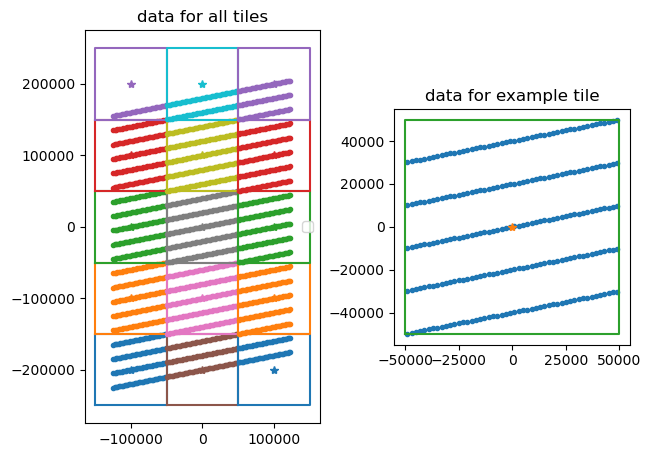

In [22]:
D_index = schema.tile_xy(data=D, return_dict=True)

hf, hax=plt.subplots(1, 2, layout='constrained')
plt.sca(hax[0])
#box=[np.array([-1, 1, 1, -1, -1])*schema.tile_spacing/2,
#     np.array([1, 1, -1, -1, 1])*schema.tile_spacing/2]
for tile_xy, ii in D_index.items():
    boundary = schema.tile_boundary(tile_xy)
    color=plt.plot(D.x[ii], D.y[ii],'.')[0].get_color()
    plt.plot(tile_xy[0], tile_xy[1], '*', color=color)
    plt.plot(boundary[0], boundary[1], color=color)
             
plt.gca().set_aspect(1)
plt.legend()
plt.gca().set_title('data for all tiles')

plt.sca(hax[1])
tile_xy=(0.,0.)
ii = D_index[tile_xy]
color=plt.plot(D.x[ii], D.y[ii],'.')[0].get_color()
plt.plot(tile_xy[0], tile_xy[1], '*')
boundary = schema.tile_boundary(tile_xy)
plt.plot(boundary[0], boundary[1])         
plt.gca().set_aspect(1)
plt.gca().set_title('data for example tile')

## Writing data using a schema
The schema.write_tiles() function writes data to a set of files.  By default it uses the pc.indexedH5 class to write tiles that are themselves tiled at a scale defined by the bin_size keyword. 

In [32]:
schema.write_tiles(D, bin_size=1.e4, replace=True)
! ls {schema.directory}


E0_N0.h5     E0_N200.h5      E-100_N100.h5   E-100_N200.h5  E-200_N-100.h5
E0_N-100.h5  E-100_N0.h5     E100_N-100.h5   E100_N-200.h5  E-200_N100.h5
E0_N100.h5   E100_N0.h5      E100_N100.h5    E100_N200.h5   E-200_N-200.h5
E0_N-200.h5  E-100_N-100.h5  E-100_N-200.h5  E-200_N0.h5    E-200_N200.h5


The schema.file_xy function recovers the locations of the written-out files:

Text(0.5, 1.0, 'tile boundaries')

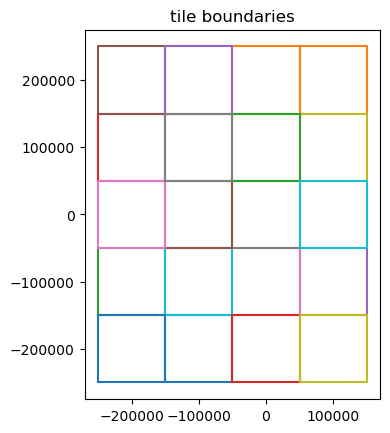

In [24]:
plt.figure()
file_xy=schema.file_xy()
for jj in file_xy:
    plt.plot(*schema.tile_boundary(jj))
plt.gca().set_aspect(1)
plt.gca().set_title('tile boundaries')

## Reading data from a schema
We can find the tiles in a schema that intersect a set of data using the schema.tile_xy with a set of points around which we would like to recover data.  This returns all the tiles that intersect with the data points.  The all_tiles keyword specifies that tiles that are adjacent to the query points (with a tolerance specified by schema.bin_size):

Text(0.5, 1.0, 'data query')

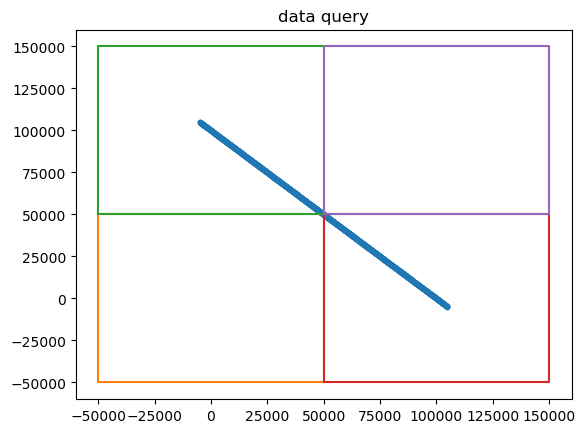

In [25]:
xyq = [np.arange(-5.5e4, 5.5e4, 100)+5e4, np.arange(5.5e4, -5.5e4, -100)+5e4]
xyT = schema.tile_xy(xy=xyq, all_tiles=True, unique=True)

plt.plot(*xyq,'.')
for xy in xyT:
    plt.plot(*schema.tile_boundary(xy), label='query points')
plt.gca().set_title('data query')

To recover the data, we just loop over the tiles:

In [26]:
filenames=schema.filenames_for_xy(xyq)
D_read = []
fields=['x','y','z','time']
for filename in filenames:
    D_read.append(pc.indexedH5.data(filename=filename).read(np.round(np.c_[xyq]/1.e4).T*1.e4, fields=fields))

Text(0.5, 1.0, 'data returned for a tilingSchema query')

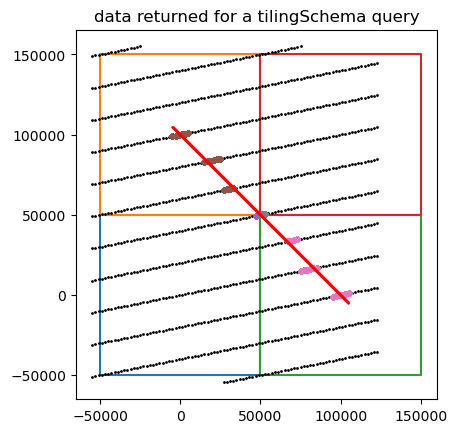

In [31]:
plt.figure()

for xy in schema.tile_xy(xy=xyq, all_tiles=True, unique=True):
    plt.plot(*schema.tile_boundary(xy))

bounds = [np.array([np.min(jj), np.max(jj)])+np.array([-5.e4, 5.e4]) for jj in xyq]

Dsub=D.cropped(bounds)
plt.plot(Dsub.x, Dsub.y,'k.', label='all data', markersize=2)

for jj in D_read:
    plt.plot(jj.x, jj.y,'.', label='data from query')

plt.plot(*xyq,'r.', markersize=1)
plt.gca().set_aspect(1)

plt.gca().set_title('data returned for a tilingSchema query')

# Note on the mapping function:

currently, the tiling schemas are best tested with np.round as the tiling function.  This is not optimal, because for common combinations of tile size and bin size, bins on the boundary can be split between adjacent tiles. A better option would be to use np.floor, which would define the tiles and bins by their lower-left corner.  At present this option is not enabled in pc.indexedH5, but it could be without a lot of trouble.

